# Proyecto de análisis de sentimientos con Python


Curso 2022/2023

    Juan López Quirós
    
    Jose Ignacio Castro Vázquez

 Lo primero que hay que hacer es escoger o recopilar una primera versión de los datos necesarios que utilizarmos 
 para entrenar a nuestros modelos de Aprendizaje automático. 
 Tras haber estudiado los varios problemas con la API de twitter y las alternativas propuestas, nos decidimos por 
 buscar un dataset ya recopilado de tweets reales de la página web kaggle. En concreto nos decidimos por un dataset
 ya enfocado al análisis de sentimientos con más de 1.6 millones de tweets recopilados directamente de la API de twitter
 por lo que se ajusta perfectamente al proyecto.

 url : https://www.kaggle.com/datasets/kazanova/sentiment140

 Luego, tenemos que limpiar el dataset escogido para este proyecto.
 A nosotros solo nos interesa una columna en particular de todo el dataset y ese es la columna de texto, que contiene
 el contenido de los tweets en sí. Para leer el fichero de datos y procesarlo, utilizaremos pandas.

In [1]:
import pandas as pd

Definimos la función que se encarga de leer y procesar el fichero de datos. Esta función eliminará las columnas irrelevantes, seleccionará un subset de 5000 tweets que formará el corpus de nuestros modelos y por último los guardará en otro fichero para su uso más adelante.

In [2]:
def create_cleaned_csv(original_filename, target_filename):
    #uft-8 encoding didn't work, latin1 encoding did.
    data = pd.read_csv(original_filename, encoding="latin1", header=None)

    #We give the columns a name
    column_names = ["target", "id", "date", "flag", "user", "text"]
    data.columns = column_names

    #We eliminate innecessary columns
    data.drop(columns=["target", "id", "date", "flag", "user"], inplace=True)

    #We select a subset of 5000 tweets
    data = data[:5000]

    #Save data onto new file
    data.to_csv(target_filename, index=False)
    print("FINAL RESULT: \n")
    print(data)

In [3]:
create_cleaned_csv("tweet_data.csv", "subset_tweet_data.csv")        

FINAL RESULT: 

                                                   text
0     @switchfoot http://twitpic.com/2y1zl - Awww, t...
1     is upset that he can't update his Facebook by ...
2     @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire 
4     @nationwideclass no, it's not behaving at all....
...                                                 ...
4995                                    long day today 
4996                     a friend broke his promises.. 
4997               @gjarnling I am fine thanks - tired 
4998          trying to keep my eyes open..damn baking 
4999                        why the hell is it snowing 

[5000 rows x 1 columns]


A continuación, utilizamos la libreria NLTK para limpiar, tokenizar y lematizar nuestro dataset.

Para esto, descargamos los recursos necesarios para trabajar con la librería nltk.

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Para asegurarnos de que el recurso que contiene las stopwords se descargó correctamente, los mostramos por pantalla.

In [5]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'not', 'out', 'in', 'was', 'herself', 'doing', 'such', 'no', 'is', 'as', "shan't", "you've", 'so', "don't", 'when', 'nor', 'theirs', 'does', 'here', 'ain', 'its', 'how', 'she', 'more', 'i', 'it', 'these', 'be', 'had', 'who', 'our', 'just', 'shan', 'very', "shouldn't", "aren't", 'my', "hasn't", 'me', 'further', 'whom', 'few', 'to', 'against', "haven't", 'been', 'if', 'from', 'didn', 'doesn', 'most', 'have', "it's", 'same', 'o', 'through', 'by', 'between', 'off', 'm', 'y', 'which', 'hasn', 'll', 'itself', 'where', "you'd", 'hers', 'having', 'them', 'below', 'their', 'because', 'or', 'into', 'myself', 'has', 'each', 'own', "you'll", 'a', "mightn't", 'shouldn', 'under', "isn't", 'needn', 'any', 'of', 'her', 'that', "hadn't", 'ma', 'before', 'and', "weren't", 'after', 'an', 'down', 'hadn', "mustn't", 'until', 'then', "she's", 'wasn', 'will', "should've", 'don', 'yours', 'both', 'now', 'haven', 'over', "wouldn't", "needn't", 'can', 'for', 'during', 'there', 'mustn', 'with', 'being', 'were',

Definimos la función encargada de limpiar los tweets del dataset que eliminará las menciones, hashtags, urls y otros símbolos extraños contenidos en ellos.

Además después de pasar por este filtro, los tokenizamos con TweetTokenizer que a diferencia del tokenizador por defecto de NLTK, word_tokenizer, este si mantiene la coherencia en palabras complejas del inglés.

Por ejemplo la palabra "can't":
- Con word_tokenizer-> can't = ["ca", "n't"]
- Con TweetTokenize-> can't = ["can't"]

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from string import punctuation

def clean_text(original_filename, target_filename, with_punctuation=True):
    data = pd.read_csv(original_filename, encoding="latin1")
    stop_words = set(stopwords.words('english'))
    mention_or_hashtag_characters = ["@", "#"]

    tt = TweetTokenizer() #Tokenizer
    ps = PorterStemmer() #Stemmer

    for i, row in data.iterrows():
        tweet = data.iloc[i]["text"]

        tweet_tokens = tt.tokenize(tweet) #Tokenizing

        filtered_tweet_tokens = [token for token in tweet_tokens if 
                                    token.lower()[0] not in mention_or_hashtag_characters and #Eliminate mentions, hashtags
                                    token.lower() not in stop_words and #Eliminate stop words
                                    'http' not in token.lower()] #Eliminate urls

        if(not with_punctuation):
            filtered_tweet_tokens = [token for token in filtered_tweet_tokens if token not in list(punctuation)]

        stemmed_tweet_tokens = [ps.stem(token) for token in filtered_tweet_tokens] #Stemming
        
        data.loc[i,['text']] = ' '.join(str(token) for token in stemmed_tweet_tokens)

    data.to_csv(target_filename, index=False)

        


Hacemos 2 llamadas a la función. La primera para el corpus sea texto con signos de puntuación inclusive y otro con texto puramente alfanumérico, esto lo hacemos así para estudiar el posible impacto que puedan tener estos en los modelos finales. 

In [7]:
clean_text('subset_tweet_data.csv', 'tokenized_data.csv')
clean_text('subset_tweet_data.csv', 'tokenized_data_no_punctuation.csv', False)

El siguiente paso consisitirá en utilizar la librería TextBlob para la clasificacion de los tweets en: Muy Feliz, Contento, Neutro, Molesto, Hater.

Para ello primero debemos definir los términos y qué consideraremos como 'Neutro', 'Hater', etc..
TextBlob mediante su función 'TextBlob.sentiment' nos hace un análisis de sentimientos de cualquier texto en forma de Objeto Sentiment, un objeto que tiene 2 parámetros:

    - Polarity con rango [-1,1] que indica la polaridad del sentimiento del texto siendo -1 un texto muy negativo y 1 muy positivo
    
    - Subjectivity con rango [0,1] que indica la objetividad del texto siendo 0 muy objetivo y cercano a la realidad y 1 siendo muy subjetivo donde se expresan más las opiniones y sentimientos personales del autor.

Teniendo en cuenta las limitaciones del procesamiento de análsis de Textblob definiremos:

    - Muy Feliz: Polarity=(0.25,1] Subjectivity=[0-0.5)
    - Contento: Polarity=(0.25,1] Subjectivity=[0.5-1]
    - Neutro: Polarity=(-0.25,0.25] Subjectivity=any
    - Hater: Polarity=[-1,-0.25) Subjectivity=[0-0.5)
    - Molesto: Polarity=[-1,-0.25) Subjectivity=[0.5-1]
    
    Esto lo hacemos así ya que consideramos que la principal diferencia entre "Muy Feliz"-"Contento" y "Hater"-"Molesto" es que los primeros son opiniones más subjetivas que las segundas. Y por otra parte consideramos que si el texto es muy objetivo decimos que es neutro ya que no expresa sentimiento ninguno de la persona que escribe el tweet.

In [8]:
from textblob import TextBlob

def classify_tweets(original_filename, target_filename):
    data = pd.read_csv(original_filename, encoding="latin1")
    dic_count = dict()
    for i, row in data.iterrows():
        tweet = TextBlob(str(data.iloc[i]["text"]))
        sentiment = tweet.sentiment
        tag = choose_classification(sentiment)
        data.loc[i,['tag']] = tag

        if tag not in dic_count:
            dic_count[tag] = 1
        else:
            dic_count[tag] = dic_count[tag] + 1

    print(dic_count)
    data.to_csv(target_filename, index=False)


def choose_classification(sentiment):
    classification = "Neutral"
    polarity = sentiment.polarity 
    subjectivity = sentiment.subjectivity 
    if polarity < -0.25:
        classification = "Molesto"
        if subjectivity < 0.5:
            classification = "Hater"
    elif polarity > 0.25:
        classification = "Contento"
        if subjectivity < 0.5:
            classification = "Muy Feliz"
    return classification


Probamos la clasificación de los tweets en los 2 datasets uno con signos de puntuación y otro sin ellos. Podemos ver, por los diccionarios contadores calculados, que devuelven resultados muy parecidos.

In [9]:
classify_tweets("tokenized_data_no_punctuation.csv", "final_dataset.csv")
classify_tweets("tokenized_data.csv", "final_dataset_punctuation.csv")

{'Neutral': 3516, 'Molesto': 656, 'Contento': 596, 'Hater': 80, 'Muy Feliz': 152}
{'Neutral': 3467, 'Molesto': 667, 'Contento': 611, 'Hater': 83, 'Muy Feliz': 172}


Tras la revisión manual de los dataset, el siguiente paso es la implementación de distintos algoritmos de aprendizaje automático. Tras una investigación previa, decidimos implementar estos 3 tipos de modelo:

    - Naive Bayes
    - Support Vector Machine (SVM)
    - Convolutional Neural Network (CNN)

Implementamos la función que nos convertirá el texto a vectores para su mejor manejo.

In [10]:
# Naiive Bayes a implementar: Gaussian, Multinomial, Complement, Bernoulli
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def tfidf_vectorize_data(original_filename):
    data = pd.read_csv(original_filename, encoding="latin1")
    X = data['text'].values.astype('U')
    y = data['tag']
    #Vectorize data
    tag_encoder = LabelEncoder()
    vectorizer = TfidfVectorizer(encoding='latin1', ngram_range=(1,2))
    vectorized_X = vectorizer.fit_transform(X)
    #Encode tags
    encoded_y = tag_encoder.fit_transform(y)
    return vectorized_X, encoded_y

X, y = tfidf_vectorize_data("final_dataset.csv")

# Implementación y estudio de modelos SVM

En este siguiente paso, vamos a entrenar el algoritmo SVC (support vector classification) con nuestro dataset.

 Lo primero que haremos es ver como se comporta el modelo en función del hiperparametro C y afecta a la predicción de sentimientos.
 A mayor valor de C mayor penalización habrá y por tanto se adherirá a los datos del training set más adecuadamente.
 A menor valor de C menos penalizaciones y más margen de error por lo que será menos preciso, pero así evitamos el overfitting.

In [11]:
from sklearn import svm

#Hacemos split de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True)

for i in range(1,20):
    decimal = i/10
    classification = svm.SVC(kernel='linear', C=float(decimal)).fit(X_train, y_train)
    score = classification.score(X_test, y_test)
    print(decimal, str(score*100)+"%")


0.1 69.89999999999999%
0.2 70.3%
0.3 70.8%
0.4 72.3%
0.5 73.6%
0.6 75.1%
0.7 76.2%
0.8 77.2%
0.9 78.10000000000001%
1.0 78.9%
1.1 79.5%
1.2 80.10000000000001%
1.3 80.5%
1.4 80.7%
1.5 80.80000000000001%
1.6 80.7%
1.7 80.80000000000001%
1.8 80.7%
1.9 80.80000000000001%


Vemos que efectivamente con mayor valor del hiperparametro C más preciso es nuestro modeloa aunque vemos que los valores de exactitud se estancan alrededor de un 80.7% cuando C>=1.4 por lo tanto a mayor valor de C una vez alcanzado el valor 1.4, este no mejora el rendimiento global del modelo.

Aún así, corremos el riesgo de overfitting del modelo a nuestro dataset. Para solucionarlo, importamos de sklearn la herramienta cross_val_score para hacer validación cruzada del dataset que se encargará de dividir el dataset en k pliegues y utilizar distintas partes del dataset como trainingSet y testSet.

Este proceso lo aplicaremos a 4 tipos que tiene el modelo svc: lineal, polinomial, sigmoide y gaussiano

In [12]:
from sklearn.model_selection import cross_val_score

X, y = tfidf_vectorize_data("final_dataset.csv")
#linear, poly, rbf(gaussian), sigmoid                    #same random state (deterministic result)
classification_svc_linear = svm.SVC(kernel='linear', C=1.5, random_state=17)
classification_svc_polynomial = svm.SVC(kernel='poly', C=1.5, random_state=17)
classification_svc_gaussian = svm.SVC(kernel='rbf', C=1.5, random_state=17)
classification_svc_sigmoid = svm.SVC(kernel='sigmoid', C=1.5, random_state=17)

svc_scores = dict()

score = cross_val_score(classification_svc_linear, X, y, cv=5)
svc_scores['linear'] = score

score = cross_val_score(classification_svc_polynomial, X, y, cv=5)
svc_scores['polynomial'] = score

score = cross_val_score(classification_svc_gaussian, X, y, cv=5)
svc_scores['gaussian'] = score

score = cross_val_score(classification_svc_sigmoid, X, y, cv=5)
svc_scores['sigmoid'] = score

print(svc_scores)



{'linear': array([0.82 , 0.805, 0.81 , 0.795, 0.801]), 'polynomial': array([0.706, 0.708, 0.71 , 0.706, 0.708]), 'gaussian': array([0.751, 0.741, 0.754, 0.731, 0.738]), 'sigmoid': array([0.828, 0.811, 0.813, 0.794, 0.8  ])}


Podemos sacar bastantes conclusiones de aqui, pero tras investigar algo mas en la libreria sklearn encontramos otra funcion: cross_validate que permite varias metricas a evaluar. Por lo tanto aplicamos esta nueva función.

Usaremos scoring_metrics para almacenar las métricas que queremos evaluar de los modelos como: accuracy, precision, recall y f1

Usamos Macro-averaging, así calcularemos la precision de cada una de las posibles clasificaciones y les dará el mismo peso, de esta forma mitigaremos el posible efecto que pueda tener el que haya muchos ejemplos del dataset con una misma clase y por tanto solo darnos la precision de una clasificación en concreto.

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

X, y = tfidf_vectorize_data("final_dataset.csv")

svc_scores = dict()

#Creamos scoring_metrics para decirle a cross-validate las metricas que nos interesa saber de nuestros modelos
scoring_metrics = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='macro', zero_division="warn"), #zero_division-> precision=TP/TP+FP, handles when there are no TP.
           'recall': make_scorer(recall_score, average='macro'),                             #elegimos warn para hacernos saber si el modelo no detecta TP.
           'f1': make_scorer(f1_score, average='macro')}                                    


Aplicamos el metodo cross_validate al modelo SVC lineal.

In [14]:
classification_svc_linear = svm.SVC(kernel='linear', C=1, random_state=17)

score = cross_validate(classification_svc_linear, X, y, cv=5, scoring=scoring_metrics)
svc_scores['linear'] = score
print(score)

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([3.12904882, 2.61070681, 2.89643049, 2.57256627, 2.5394094 ]), 'score_time': array([0.27605176, 0.31648421, 0.27977729, 0.27552319, 0.27261996]), 'test_accuracy': array([0.796, 0.788, 0.794, 0.776, 0.782]), 'test_precision': array([0.69147738, 0.88540105, 0.85142407, 0.89394457, 0.68687799]), 'test_recall': array([0.36899897, 0.38923454, 0.37806472, 0.35877088, 0.35827486]), 'test_f1': array([0.40887387, 0.45747389, 0.43759967, 0.41815365, 0.41152576])}


c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ahora obtenemos más métricas que con el método anterior y además nos damos cuenta de otro dato y es que podemos ver que el modelo SVC lineal no detecta bien los True Positive (TP) esto se debe a que al intentar hacer el calculo de precisión siendo tal que:

precision = TP/TP+FP

Nos arroja el error 'zero_division'. Esto solo puede darse si el denominador es 0, por tanto, TP = 0. En este caso concreto, el error se muestra 2 veces por pantalla. Es decir, hay 2 pliegues en cuales el modelo no es capaz de identificar bien los True Positive (TP).

Nosotros queremos que nuestro modelo sea capaz de detectar los TP así que subimos el hiperparametro C a C=1.5

In [15]:
#Linear
classification_svc_linear = svm.SVC(kernel='linear', C=1.5, random_state=17)

score = cross_validate(classification_svc_linear, X, y, cv=5, scoring=scoring_metrics)
svc_scores['linear'] = score

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ahora el error solo se aparece en 1 pliegue, lo que mantiene la coherencia con lo visto anteriormente de mayor precisión a mayor valor de C en nuestro modelo.

En las siguientes casillas calcularemos las métricas de los distintos tipos de SVC que hay como lineal, polinomial, gausiano y sigmoide usando C=1.5 ya que hemos demostrado que es un valor que optimiza el rendimiento del modelo.

In [16]:
#Polynomial
classification_svc_polynomial = svm.SVC(kernel='poly', C=1.5, random_state=17)

score = cross_validate(classification_svc_polynomial, X, y, cv=5, scoring=scoring_metrics)
svc_scores['poly'] = score

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

In [17]:
#Gaussian
classification_svc_gaussian = svm.SVC(kernel='rbf', C=1.5, random_state=17)

score = cross_validate(classification_svc_gaussian, X, y, cv=5, scoring=scoring_metrics)
svc_scores['gaussian'] = score


c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

In [18]:
#Sigmoid
classification_svc_sigmoid = svm.SVC(kernel='sigmoid', C=1.5, random_state=17)

score = cross_validate(classification_svc_sigmoid, X, y, cv=5, scoring=scoring_metrics)
svc_scores['sigmoid'] = score

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Viendo los mensajes de error, podemos intuir que el gaussiano y polinomial se comportan mucho peor que los modelos lineal y sigmoide al tener los primeros problemas detectando los TP en los 5 pliegues mientras que los segundos solo en 1.

A continuación, vamos a representar las métricas obtenidas en un gráfico de barras para su mejor estudio.

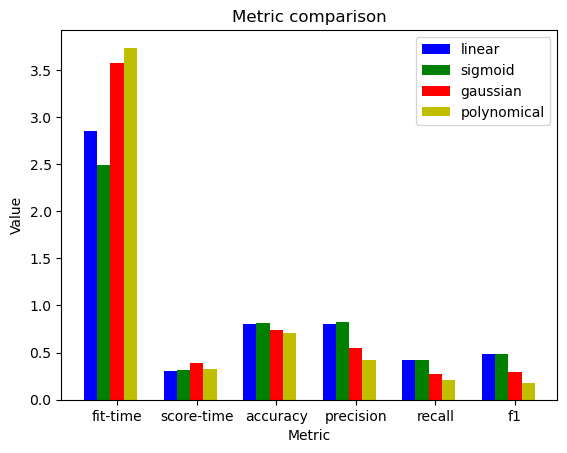

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_mean_metrics(metrics_dict):
    metrics = []
    for x in metrics_dict.items():
        metric_values = x[1]
        metric_mean = np.mean(metric_values)
        metrics.append(metric_mean)
    return metrics

score_linear_means = calculate_mean_metrics(svc_scores['linear'])
score_sigmoid_means = calculate_mean_metrics(svc_scores['sigmoid'])
score_gaussian_means = calculate_mean_metrics(svc_scores['gaussian'])
score_poly_means = calculate_mean_metrics(svc_scores['poly'])

#Calculamos el grafico de barras para ver visualmente como se comparan las métricas de cada modelo.
metric_categories = ['fit-time', 'score-time', 'accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind-0.50, score_linear_means, color = 'b', width = width_bar, label='linear')
rect2 = ax.bar(ind-0.25, score_sigmoid_means, color = 'g', width = width_bar, label='sigmoid')
rect3 = ax.bar(ind+0, score_gaussian_means, color = 'r', width = width_bar, label='gaussian')
rect4 = ax.bar(ind+0.25, score_poly_means, color = 'y', width = width_bar, label='polynomical')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()




Como intuíamos antes constante vemos que hay 2 modelos que sobresalen al identificar mejor los TP que el resto, y estos son:

    - Sigmoide y Lineal

No solo son más rápidos que los otros dos modelos, sino que además se ve una clara mejora en el rendimiento de las métricas como 'accuracy', 'precision', 'recall, y 'f1'

Aislaremos las métricas de estos 2 modelos para sacar una conclusión final.

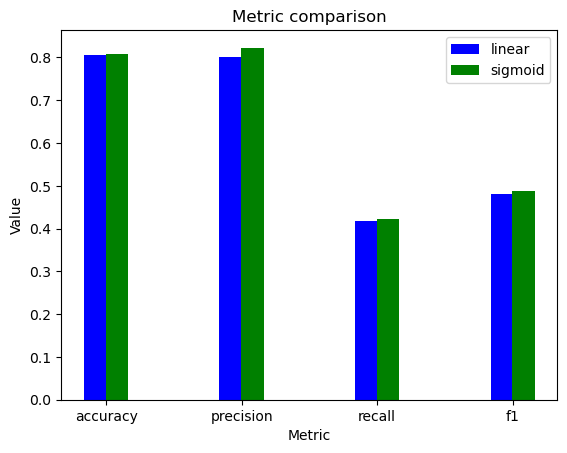

In [20]:
#Calculamos el grafico de barras para ver visualmente como se comparan las métricas de cada modelo.
metric_categories = ['accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind-0.12, score_linear_means[2:], color = 'b', width = width_bar, label='linear')
rect2 = ax.bar(ind+0.12, score_sigmoid_means[2:], color = 'g', width = width_bar, label='sigmoid')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()

Observamos que ambos modelos se comportan de forma muy similar, rondando los mismos valores en todas las métricas, aunque se aprecia una leve mejora de los resultados con el modelo sigmoide y es más rápido respecto al lineal.

En conclusión, tras evaluar los distintos tipos de modelo svm.SVC que nos proporciona sklearn el modelo que mejor se adapta y nos arroja mejores resultados con nuestro conjunto de pruebas es el modelo sigmoide al tener el mejor rendimiento y ser más rápido que el resto.

# Implementación y estudio de modelos Naive Bayes

Repetimos el mismo proceso que con SVM, esta vez con los modelos de naive bayes disponibles.

In [21]:
from sklearn.naive_bayes import *

X, y = tfidf_vectorize_data("final_dataset.csv")

nb_scores = dict()

multinomial_nb = MultinomialNB()

#cross validate uses k=5 by default   
results_multinomial = cross_validate(multinomial_nb, X, y, cv=5, scoring=scoring_metrics)
nb_scores['multinomial'] = results_multinomial
print(results_multinomial)


{'fit_time': array([0.00601101, 0.00997543, 0.00993896, 0.00698996, 0.00498605]), 'score_time': array([0.00498819, 0.00399303, 0.00398922, 0.00597501, 0.00798249]), 'test_accuracy': array([0.704, 0.703, 0.704, 0.703, 0.703]), 'test_precision': array([0.1408    , 0.1406    , 0.34074074, 0.1406    , 0.1406    ]), 'test_recall': array([0.2       , 0.2       , 0.20152672, 0.2       , 0.2       ]), 'test_f1': array([0.16525822, 0.16512038, 0.16824769, 0.16512038, 0.16512038])}


c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

In [22]:
gaussian_nb = GaussianNB()           #cambio de formato necesario para el metodo.
results_gaussian = cross_validate(gaussian_nb, X.toarray(), y, cv=5, scoring=scoring_metrics)
nb_scores['gaussian'] = results_gaussian
print(results_multinomial)

{'fit_time': array([0.00601101, 0.00997543, 0.00993896, 0.00698996, 0.00498605]), 'score_time': array([0.00498819, 0.00399303, 0.00398922, 0.00597501, 0.00798249]), 'test_accuracy': array([0.704, 0.703, 0.704, 0.703, 0.703]), 'test_precision': array([0.1408    , 0.1406    , 0.34074074, 0.1406    , 0.1406    ]), 'test_recall': array([0.2       , 0.2       , 0.20152672, 0.2       , 0.2       ]), 'test_f1': array([0.16525822, 0.16512038, 0.16824769, 0.16512038, 0.16512038])}


In [23]:
complement_nb = ComplementNB()
results_complement = cross_validate(complement_nb, X, y, cv=5, scoring=scoring_metrics)
nb_scores['complement'] = results_complement
print(results_complement)

{'fit_time': array([0.01859164, 0.01708126, 0.03079796, 0.02014565, 0.02015781]), 'score_time': array([0.00506091, 0.01254201, 0.01271582, 0.01560545, 0.01583362]), 'test_accuracy': array([0.71 , 0.668, 0.678, 0.695, 0.699]), 'test_precision': array([0.4699758 , 0.42375415, 0.4415106 , 0.46177337, 0.45362156]), 'test_recall': array([0.4923981 , 0.43991872, 0.44152668, 0.46857685, 0.41759859]), 'test_f1': array([0.46936619, 0.41848379, 0.42778499, 0.44929257, 0.42653701])}


In [24]:
bernoulli_nb = BernoulliNB()
results_bernoulli = cross_validate(bernoulli_nb, X, y, cv=5, scoring=scoring_metrics)
nb_scores['bernoulli'] = results_bernoulli

print(results_bernoulli)

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedM

{'fit_time': array([0.02596688, 0.02170086, 0.02283549, 0.0192523 , 0.01949716]), 'score_time': array([0.01813388, 0.02584434, 0.02958322, 0.0427177 , 0.01993728]), 'test_accuracy': array([0.704, 0.703, 0.703, 0.703, 0.703]), 'test_precision': array([0.1408, 0.1406, 0.1406, 0.1406, 0.1406]), 'test_recall': array([0.2, 0.2, 0.2, 0.2, 0.2]), 'test_f1': array([0.16525822, 0.16512038, 0.16512038, 0.16512038, 0.16512038])}


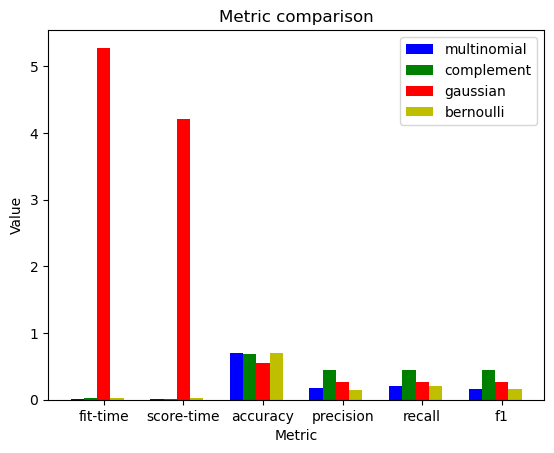

In [25]:
score_multinomial_means = calculate_mean_metrics(nb_scores['multinomial'])
score_complement_means = calculate_mean_metrics(nb_scores['complement'])
score_gaussian_means = calculate_mean_metrics(nb_scores['gaussian'])
score_bernoulli_means = calculate_mean_metrics(nb_scores['bernoulli'])

#Calculamos el grafico de barras para ver visualmente como se comparan las métricas de cada modelo.
metric_categories = ['fit-time', 'score-time', 'accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind-0.50, score_multinomial_means, color = 'b', width = width_bar, label='multinomial')
rect2 = ax.bar(ind-0.25, score_complement_means, color = 'g', width = width_bar, label='complement')
rect3 = ax.bar(ind+0, score_gaussian_means, color = 'r', width = width_bar, label='gaussian')
rect4 = ax.bar(ind+0.25, score_bernoulli_means, color = 'y', width = width_bar, label='bernoulli')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()

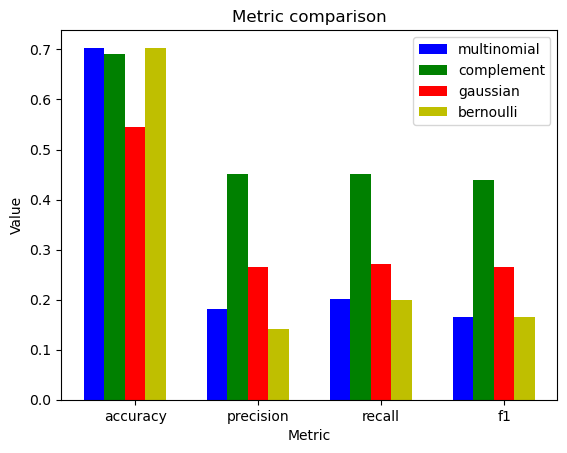

In [28]:

#Calculamos el grafico de barras para ver visualmente como se comparan las métricas de cada modelo.
metric_categories = ['accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind-0.50, score_multinomial_means[2:], color = 'b', width = width_bar, label='multinomial')
rect2 = ax.bar(ind-0.25, score_complement_means[2:], color = 'g', width = width_bar, label='complement')
rect3 = ax.bar(ind+0, score_gaussian_means[2:], color = 'r', width = width_bar, label='gaussian')
rect4 = ax.bar(ind+0.25, score_bernoulli_means[2:], color = 'y', width = width_bar, label='bernoulli')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()

# Neural Network

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler(with_mean = False)  

scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Probamos con distintos solver para MLPClassifier, manteniendo el resto constante

In [40]:
mlp_sgd_relu = MLPClassifier(hidden_layer_sizes = (5,5,5), max_iter = 10, activation='relu', solver = 'sgd')
mlp_adam_relu = MLPClassifier(hidden_layer_sizes = (5,5,5), max_iter = 10, activation='relu', solver = 'adam')
mlp_lbfgs_relu = MLPClassifier(hidden_layer_sizes = (5,5,5), max_iter = 10, activation='relu', solver = 'lbfgs')

mlp_sgd_relu.fit(X_train, y_train)
mlp_adam_relu.fit(X_train, y_train)
mlp_lbfgs_relu.fit(X_train, y_train)

#predictions = mlp.predict(X_test)

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=(5, 5, 5), max_iter=10, solver='lbfgs')

In [41]:
from sklearn.metrics import classification_report

#report = classification_report(y_test,predictions)
#print(report)

results_nn_sgd = cross_validate(mlp_sgd_relu, X, y, cv=5, scoring=scoring_metrics)
results_nn_adam = cross_validate(mlp_adam_relu, X, y, cv=5, scoring=scoring_metrics)
results_nn_lbfgs = cross_validate(mlp_lbfgs_relu, X, y, cv=5, scoring=scoring_metrics)

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

In [42]:
print(results_nn_sgd)
print(results_nn_adam)
print(results_nn_lbfgs)

{'fit_time': array([1.59175563, 1.62040997, 1.54069805, 1.46405697, 1.64830995]), 'score_time': array([0.00598407, 0.00398922, 0.004987  , 0.00398922, 0.00599241]), 'test_accuracy': array([0.704, 0.703, 0.703, 0.703, 0.703]), 'test_precision': array([0.1408, 0.1406, 0.1406, 0.1406, 0.1406]), 'test_recall': array([0.2, 0.2, 0.2, 0.2, 0.2]), 'test_f1': array([0.16525822, 0.16512038, 0.16512038, 0.16512038, 0.16512038])}
{'fit_time': array([2.85254598, 2.05812192, 2.13006043, 2.10140514, 2.39723754]), 'score_time': array([0.00299311, 0.00398254, 0.00498652, 0.00598311, 0.0039885 ]), 'test_accuracy': array([0.704, 0.703, 0.703, 0.703, 0.703]), 'test_precision': array([0.1408    , 0.1406    , 0.1406    , 0.14130653, 0.1406    ]), 'test_recall': array([0.2, 0.2, 0.2, 0.2, 0.2]), 'test_f1': array([0.16525822, 0.16512038, 0.16512038, 0.1656066 , 0.16512038])}
{'fit_time': array([0.5457027 , 0.7138145 , 0.77401781, 0.84750295, 0.64662766]), 'score_time': array([0.00499177, 0.00598407, 0.0039885

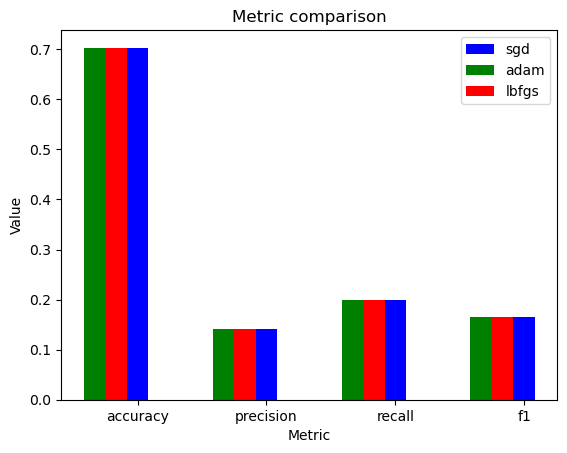

In [43]:
nn_sgd_mean_metrics = calculate_mean_metrics(results_nn_sgd)
nn_adam_mean_metrics = calculate_mean_metrics(results_nn_adam)
nn_lbfgs_mean_metrics = calculate_mean_metrics(results_nn_lbfgs)

metric_categories = ['accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind+0, nn_sgd_mean_metrics[2:], color = 'b', width = width_bar, label='sgd')
rect2 = ax.bar(ind-0.50, nn_adam_mean_metrics[2:], color = 'g', width = width_bar, label='adam')
rect3 = ax.bar(ind-0.25, nn_lbfgs_mean_metrics[2:], color = 'r', width = width_bar, label='lbfgs')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()

Al arrojarnos los 3 datos idénticos, escogeremos uno y experimentaremos con el para intentar mejorar el rendimiento. Nosotros escogimos el solver sgd.

In [46]:
mlp_sgd_relu = MLPClassifier(hidden_layer_sizes = (5,5,5), max_iter = 10, activation='relu', solver = 'sgd')
mlp_sgd_more_iterations = MLPClassifier(hidden_layer_sizes = (5,5,5), max_iter = 20, activation='relu', solver = 'sgd')
mlp_sgd_tanh = MLPClassifier(hidden_layer_sizes = (5,5,5), max_iter = 10, activation='tanh', solver = 'sgd')
mlp_sgd_more_layers = MLPClassifier(hidden_layer_sizes = (5,5,5,5), max_iter = 10, activation='tanh', solver = 'sgd')
mlp_sgd_more_neurons = MLPClassifier(hidden_layer_sizes = (10,10,10), max_iter = 10, activation='tanh', solver = 'sgd')

mlp_sgd_relu.fit(X_train, y_train)
mlp_sgd_more_iterations.fit(X_train, y_train)
mlp_sgd_tanh.fit(X_train, y_train)
mlp_sgd_more_layers.fit(X_train, y_train)
mlp_sgd_more_neurons.fit(X_train, y_train)


c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10, 10), max_iter=10,
              solver='sgd')

In [47]:
results_nn_sgd = cross_validate(mlp_sgd_relu, X, y, cv=5, scoring=scoring_metrics)
results_nn_sgd_more_iterations = cross_validate(mlp_sgd_more_iterations, X, y, cv=5, scoring=scoring_metrics)
results_nn_sgd_tanh = cross_validate(mlp_sgd_tanh, X, y, cv=5, scoring=scoring_metrics)
results_nn_sgd_more_layers = cross_validate(mlp_sgd_more_layers, X, y, cv=5, scoring=scoring_metrics)
results_nn_sgd_more_neurons = cross_validate(mlp_sgd_more_neurons, X, y, cv=5, scoring=scoring_metrics)


c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juanq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

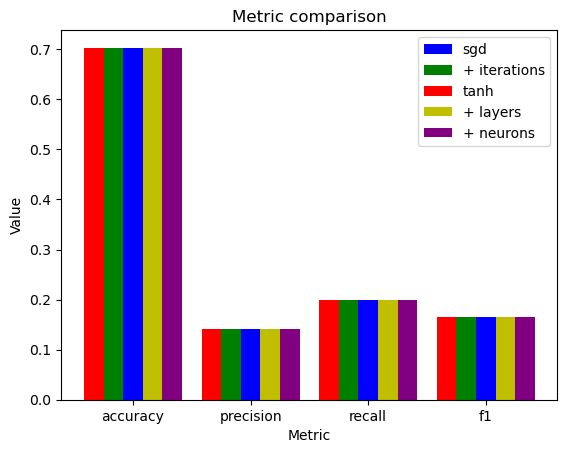

In [50]:
nn_sgd_mean_metrics = calculate_mean_metrics(results_nn_sgd)
results_nn_sgd_more_iterations_metrics = calculate_mean_metrics(results_nn_sgd_more_iterations)
results_nn_sgd_tanh_metrics = calculate_mean_metrics(results_nn_sgd_tanh)
results_nn_sgd_more_layers_metrics = calculate_mean_metrics(results_nn_sgd_more_layers)
results_nn_sgd_more_neurons_metrics = calculate_mean_metrics(results_nn_sgd_more_neurons)

metric_categories = ['accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind+0, nn_sgd_mean_metrics[2:], color = 'b', width = width_bar, label='sgd')
rect2 = ax.bar(ind-0.25, results_nn_sgd_more_iterations_metrics[2:], color = 'g', width = width_bar, label='+ iterations')
rect3 = ax.bar(ind-0.50, results_nn_sgd_tanh_metrics[2:], color = 'r', width = width_bar, label='tanh')
rect3 = ax.bar(ind+0.25, results_nn_sgd_more_layers_metrics[2:], color = 'y', width = width_bar, label='+ layers')
rect3 = ax.bar(ind+0.50, results_nn_sgd_more_neurons_metrics[2:], color = 'purple', width = width_bar, label='+ neurons')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()

Mismos resultados que antes, esto se puede deber a que en ninguno de los modelos alcanza a converger la optimización y por tanto no se puede optimizar el resultado, quizá el dataset es demasiado pequeño o hay que implementar muchas épocas para poder alcanzar un mínimo local en el descenso por el gradiente.

En la siguiente celda hemos intentado una implementación con más generaciones y mas neuronas pero el tiempo que consume este modelo lo hace inviable tomándose hasta 10min para completar el entrenamiento y calcular sus métricas mediante evaluación cruzada.

In [51]:
# Menos precisa
'''
mlp_sgd = MLPClassifier(hidden_layer_sizes = (20,15,10,5), max_iter = 6000, solver = 'sgd', alpha = 1)
mlp_adam = MLPClassifier(hidden_layer_sizes = (20,15,10,5), max_iter = 6000, solver = 'adam', alpha = 1)
mlp_lbfgs = MLPClassifier(hidden_layer_sizes = (20,15,10,5), max_iter = 6000, solver = 'lbfgs', alpha = 1)

mlp_sgd.fit(X_train, y_train)
mlp_adam.fit(X_train, y_train)
mlp_lbfgs.fit(X_train, y_train)

results_nn_sgd = cross_validate(mlp_sgd, X, y, cv=5, scoring=scoring_metrics)
results_nn_adam = cross_validate(mlp_adam, X, y, cv=5, scoring=scoring_metrics)
results_nn_lbfgs = cross_validate(mlp_lbfgs, X, y, cv=5, scoring=scoring_metrics)

nn_sgd_mean_metrics = calculate_mean_metrics(results_nn_sgd)
nn_adam_mean_metrics = calculate_mean_metrics(results_nn_adam)
nn_lbfgs_mean_metrics = calculate_mean_metrics(results_nn_lbfgs)

metric_categories = ['accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind+0, nn_sgd_mean_metrics[2:], color = 'b', width = width_bar, label='sgd')
rect2 = ax.bar(ind-0.50, nn_adam_mean_metrics[2:], color = 'g', width = width_bar, label='adam')
rect3 = ax.bar(ind-0.25, nn_lbfgs_mean_metrics[2:], color = 'r', width = width_bar, label='lbfgs')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()
'''

c:\Users\juanq\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

# CONCLUSIONES DE LA EXPERIMENTACIÓN

Tras haber experimentado con los distintos modelos hemos concluido que los mejores modelos, de cada categoría son:

    - Naive Bayes: Complemento.
    - SVM: Sigmoide.
    - NN: Cualquiera, pues devuelven resultados idénticos.

A continuación analizaremos estos tres conjuntamente y elegiremos en base las métricas el mejor modelo de los tres.

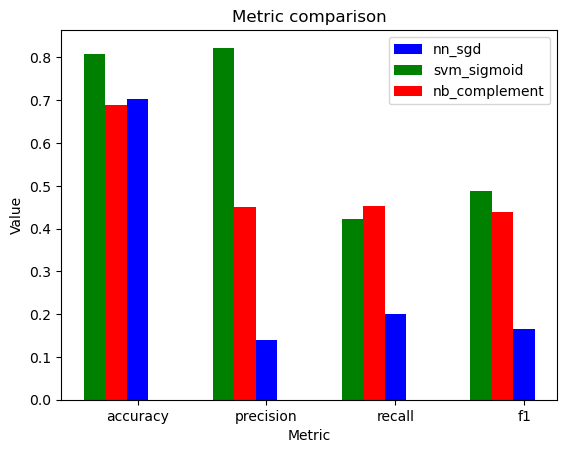

In [52]:
metric_categories = ['accuracy', 'precision', 'recall', 'f1']
N = len(metric_categories)
fig, ax = plt.subplots()
space = 1.5
ind = np.arange(0,N*space, space) 
width_bar = 0.25

rect1 = ax.bar(ind+0, nn_sgd_mean_metrics[2:], color = 'b', width = width_bar, label='nn_sgd')
rect2 = ax.bar(ind-0.50, score_sigmoid_means[2:], color = 'g', width = width_bar, label='svm_sigmoid')
rect3 = ax.bar(ind-0.25, score_complement_means[2:], color = 'r', width = width_bar, label='nb_complement')

ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Metric comparison')

ax.set_xticks(ind)
ax.set_xticklabels(metric_categories)
ax.legend()
plt.show()

El modelo SVM es el claro ganador dominando las métricas 'accuracy', 'precision', aunque por detrás del modelo naive bayes en 'recall'.

El modelo a finalmente a elegir tiene un alto grado de accuracy, por tanto clasifica correctamente hasta un 80% de los tweets. Y tiene una alta precisión, la cual de nuevo nos asegura que clasifica bien las clases positivas, positivo siendo en la clasificación multifactor la clase a predecir de donde luego se hace el macro-averaging de cada una. 

A pesar de esto, el modelo tiene un recall debajo del 50% por lo que aunque las instancias que el modelo clasifica de una clase pertenezcan realmente a esa clase (alta precisión), está perdiendo muchas instancias que deberían haber sido clasificadas en esa clase (bajo recall).

# PREDICCIÓN DE TWEETS